In [6]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import pandas as pd
import csv
from sklearn.utils import shuffle
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import os
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Roderick\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Roderick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
'''NOTES:
THIS SCRIPT RANDOMELY SPLITS THE DATASET INTO 70% TRAINING,
15% Valid, 15% Test

Change the values as needed to change training params

It is then saved into the RawData Folder as a csv. Simply
Import the csv using pandas from_csv() function to recreate
the dataframes. 

Have fun, boys. 
'''

wnl = WordNetLemmatizer()
stopW = set(stopwords.words('english'))
totalData = []

with open('SMSSpamCollection.txt', newline = '') as csvfile:
    spamreader = csv.reader(csvfile, quotechar='|')
    for row in spamreader:
        totalData.append(row[0])
        
labels = []
values = []
for row in totalData:
    try:
        row.split()[1]
        labels.append(row.split()[0]) 
        #ans = " ".join(row.split()[1:]) #lower casing text and lemmatize
        ans = row.split()[1:]
        #word_tokens = word_tokenize(ans)
        filtered_ans = [wnl.lemmatize(w) for w in ans if not w.lower() in stopW]
        filtered_ans = " ".join(filtered_ans)
        values.append(filtered_ans)
    except:
        print("opp got em chief") #do not add data without a label/value match. some only have a label
        
print(len(values), len(labels))
totalData = list(zip(labels, values))
print(totalData[:10])

totalData = pd.DataFrame(totalData)

df = shuffle(totalData)

print(totalData.head)
testData= df.iloc[int(len(df)*0.85):, :] #15%
validData = df.iloc[int(len(df)*0.7):int(len(df)*0.85), :]#15%
trainData = df.iloc[:int(len(df)*0.7), :]#70%

print(testData.shape, validData.shape, trainData.shape)
current_directory = os.getcwd()
testData.to_csv(os.path.join(current_directory, 'testData.csv'), header=None)
validData.to_csv(os.path.join(current_directory, 'validData.csv'), header=None)
trainData.to_csv(os.path.join(current_directory, 'trainData.csv'), header=None)

opp got em chief
opp got em chief
opp got em chief
opp got em chief
5570 5570
[('ham', 'Go jurong point'), ('ham', 'Ok lar... Joking wif u oni...'), ('spam', "Free entry 2 wkly comp win FA Cup final tkts 21st May 2005. Text FA 87121 receive entry question(std txt rate)T&C's apply 08452810075over18's"), ('ham', 'U dun say early hor... U c already say...'), ('ham', 'Nah think go usf'), ('spam', "FreeMsg Hey darling 3 week's word back! I'd like fun still? Tb ok! XxX std chgs send"), ('ham', 'Even brother like speak me. treat like aid patent.'), ('ham', "per request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' set callertune Callers. Press *9 copy friend Callertune"), ('spam', 'WINNER!! valued network customer selected receivea Â£900 prize reward! claim call 09061701461. Claim code KL341. Valid 12 hour only.'), ('spam', 'mobile 11 month more? U R entitled Update latest colour mobile camera Free! Call Mobile Update Co FREE 08002986030')]
<bound method NDFrame.head of          0       

In [8]:
train_data = pd.read_csv('trainData.csv', header=None)
train_data[2].fillna("", inplace=True)
train_data.iloc[:, 1] = train_data.iloc[:, 1].astype(str).map({'ham': 0, 'spam': 1}).astype(int)
train_data[1].astype(int)

0       0
1       0
2       0
3       0
4       0
       ..
3893    0
3894    1
3895    0
3896    0
3897    0
Name: 1, Length: 3898, dtype: int32

In [9]:
valid_data = pd.read_csv('validData.csv', header=None)
valid_data[2].fillna("", inplace=True)
valid_data.iloc[:, 1] = valid_data.iloc[:, 1].astype(str).map({'ham': 0, 'spam': 1}).astype(int)
valid_data[1].astype(int)

0      1
1      0
2      1
3      0
4      0
      ..
831    0
832    0
833    0
834    0
835    1
Name: 1, Length: 836, dtype: int32

In [10]:
test_data = pd.read_csv('testData.csv', header=None)
test_data[2].fillna("", inplace=True)
test_data.iloc[:, 1] = test_data.iloc[:, 1].astype(str).map({'ham': 0, 'spam': 1}).astype(int)
test_data[1].astype(int)

0      0
1      1
2      0
3      1
4      1
      ..
831    1
832    0
833    1
834    1
835    0
Name: 1, Length: 836, dtype: int32

In [11]:
print(train_data[1].value_counts())
print(valid_data[1].value_counts())
print(test_data[1].value_counts())

print(519/(519+3379))
print(110/(110+726))
print(118/(118+718))
#we can see that the dataset is imbalanced where spam is only ~13% of the dataset.

1
0    3380
1     518
Name: count, dtype: int64
1
0    726
1    110
Name: count, dtype: int64
1
0    717
1    119
Name: count, dtype: int64
0.1331452026680349
0.13157894736842105
0.14114832535885166


# Tf-idf Vectorizer

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(train_data[2])
y_train = train_data[1].astype(int)

X_valid = tfidf_vectorizer.transform(valid_data[2])
y_valid = valid_data[1].astype(int)

X_test = tfidf_vectorizer.transform(test_data[2])
y_test = test_data[1].astype(int)

train_accuracy = []
train_f1 = []
validation_accuracy = []
validation_f1 = []
test_accuracy = []
test_f1 = []

C_values = [0.001,0.01,0.1,1,10,100,1000,10000]
for c in C_values:
    base_model = SVC(C=c,kernel="linear")
    base_model.fit(X_train,y_train)
    
    y_pred_train = base_model.predict(X_train)
    y_pred_valid = base_model.predict(X_valid)
    y_pred_test = base_model.predict(X_test)
    
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    train_f1.append(f1_score(y_train, y_pred_train))
    
    validation_accuracy.append(accuracy_score(y_valid, y_pred_valid))
    validation_f1.append(f1_score(y_valid, y_pred_valid))
    
    test_accuracy.append(accuracy_score(y_test, y_pred_test))
    test_f1.append(f1_score(y_test, y_pred_test))

In [19]:
print(f'Max Training Accuracy {round(max(train_accuracy),4)} when C_value is {C_values[train_accuracy.index(max(train_accuracy))]}')
print(f'Max Training F1-Score {round(max(train_f1),4)} when C_value is {C_values[train_f1.index(max(train_f1))]} \n')
print(f'Max Validation Accuracy {round(max(validation_accuracy),4)} when C_value is {C_values[validation_accuracy.index(max(validation_accuracy))]}')
print(f'Max Validation F1-Score {round(max(validation_f1),4)} when C_value is {C_values[validation_f1.index(max(validation_f1))]} \n')
print(f'Max Test Accuracy {round(max(test_accuracy),4)} when C_value is {C_values[test_accuracy.index(max(test_accuracy))]}')
print(f'Max Test F1-Score {round(max(test_f1),4)} when C_value is {C_values[test_f1.index(max(test_f1))]}')

Max Training Accuracy 0.9987 when C_value is 100
Max Training F1-Score 0.9952 when C_value is 100 

Max Validation Accuracy 0.9809 when C_value is 10
Max Validation F1-Score 0.9223 when C_value is 10 

Max Test Accuracy 0.9761 when C_value is 1
Max Test F1-Score 0.9091 when C_value is 1


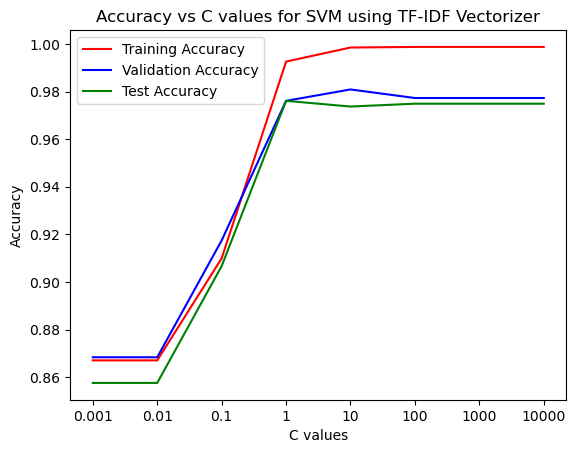

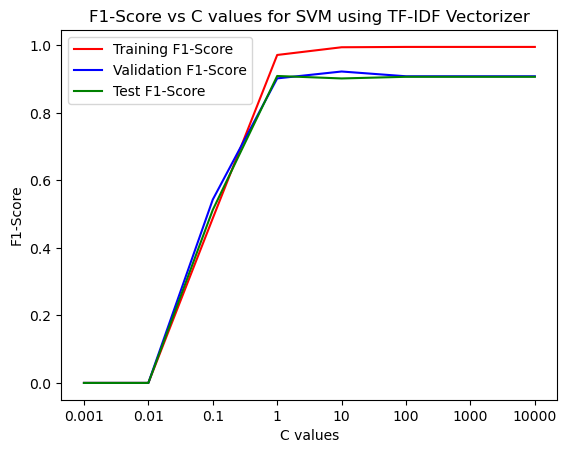

In [20]:
index = list(range(len(C_values)))

plt.plot(index, train_accuracy, linestyle='-', color='r', label='Training Accuracy')
plt.plot(index, validation_accuracy, linestyle='-', color='b', label='Validation Accuracy')  
plt.plot(index, test_accuracy, linestyle='-', color='g', label='Test Accuracy')
plt.xticks(index, C_values)
plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C values for SVM using TF-IDF Vectorizer')
plt.legend()

plt.show()

plt.plot(index, train_f1, linestyle='-', color='r', label='Training F1-Score')
plt.plot(index, validation_f1, linestyle='-', color='b', label='Validation F1-Score')  
plt.plot(index, test_f1, linestyle='-', color='g', label='Test F1-Score')
plt.xticks(index, C_values)
plt.xlabel('C values')
plt.ylabel('F1-Score')
plt.title('F1-Score vs C values for SVM using TF-IDF Vectorizer')
plt.legend()

plt.show()

In [22]:
print(f'Training Accuracy {round(train_accuracy[C_values.index(1)],4)} when C_value is 1')
print(f'Training F1-Score {round(train_f1[C_values.index(1)],4)} when C_value is 1 \n')
print(f'Validation Accuracy {round(validation_accuracy[C_values.index(1)],4)} when C_value is 1')
print(f'Validation F1-Score {round(validation_f1[C_values.index(1)],4)} when C_value is 1 \n')
print(f'Test Accuracy {round(test_accuracy[C_values.index(1)],4)} when C_value is 1')
print(f'Test F1-Score {round(test_f1[C_values.index(1)],4)} when C_value is 1')

Training Accuracy 0.9926 when C_value is 1
Training F1-Score 0.9713 when C_value is 1 

Validation Accuracy 0.9761 when C_value is 1
Validation F1-Score 0.902 when C_value is 1 

Test Accuracy 0.9761 when C_value is 1
Test F1-Score 0.9091 when C_value is 1


From the two graphs above, the model performance increases drastically from C-value of 0.01 to 1. Hence, we decided to further look into the interval to see how the model perform.

In [26]:
train_accuracy = []
train_f1 = []
validation_accuracy = []
validation_f1 = []
test_accuracy = []
test_f1 = []

C_values = [0.01,0.05,0.1,0.3,0.5,0.7,0.9,1]
for c in C_values:
    base_model = SVC(C=c,kernel="linear")
    base_model.fit(X_train,y_train)
    
    y_pred_train = base_model.predict(X_train)
    y_pred_valid = base_model.predict(X_valid)
    y_pred_test = base_model.predict(X_test)
    
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    train_f1.append(f1_score(y_train, y_pred_train))
    
    validation_accuracy.append(accuracy_score(y_valid, y_pred_valid))
    validation_f1.append(f1_score(y_valid, y_pred_valid))
    
    test_accuracy.append(accuracy_score(y_test, y_pred_test))
    test_f1.append(f1_score(y_test, y_pred_test))

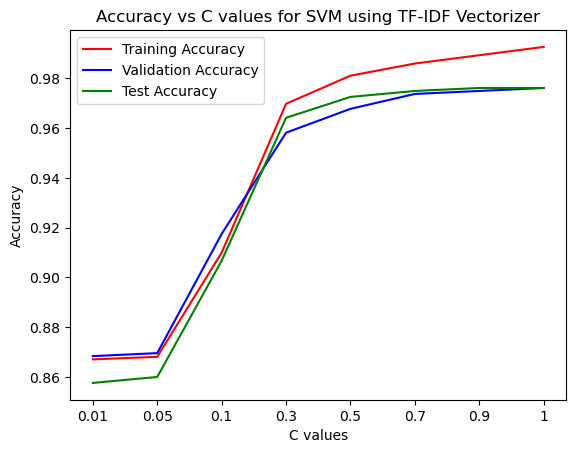

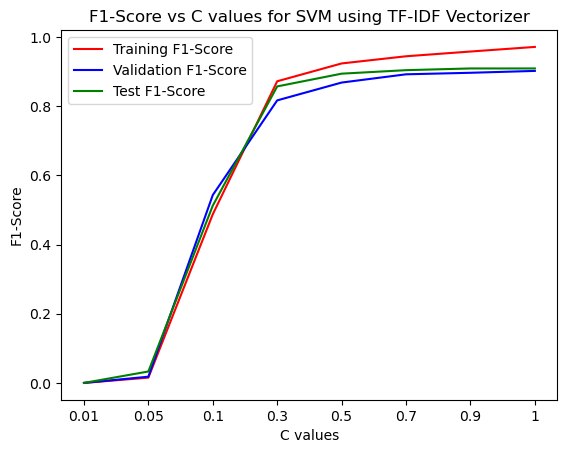

In [27]:
index = list(range(len(C_values)))

plt.plot(index, train_accuracy, linestyle='-', color='r', label='Training Accuracy')
plt.plot(index, validation_accuracy, linestyle='-', color='b', label='Validation Accuracy')  
plt.plot(index, test_accuracy, linestyle='-', color='g', label='Test Accuracy')
plt.xticks(index, C_values)
plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C values for SVM using TF-IDF Vectorizer')
plt.legend()

plt.show()

plt.plot(index, train_f1, linestyle='-', color='r', label='Training F1-Score')
plt.plot(index, validation_f1, linestyle='-', color='b', label='Validation F1-Score')  
plt.plot(index, test_f1, linestyle='-', color='g', label='Test F1-Score')
plt.xticks(index, C_values)
plt.xlabel('C values')
plt.ylabel('F1-Score')
plt.title('F1-Score vs C values for SVM using TF-IDF Vectorizer')
plt.legend()

plt.show()

In [28]:
print(f'Max Training Accuracy {round(max(train_accuracy),4)} when C_value is {C_values[train_accuracy.index(max(train_accuracy))]}')
print(f'Max Training F1-Score {round(max(train_f1),4)} when C_value is {C_values[train_f1.index(max(train_f1))]} \n')
print(f'Max Validation Accuracy {round(max(validation_accuracy),4)} when C_value is {C_values[validation_accuracy.index(max(validation_accuracy))]}')
print(f'Max Validation F1-Score {round(max(validation_f1),4)} when C_value is {C_values[validation_f1.index(max(validation_f1))]} \n')
print(f'Max Test Accuracy {round(max(test_accuracy),4)} when C_value is {C_values[test_accuracy.index(max(test_accuracy))]}')
print(f'Max Test F1-Score {round(max(test_f1),4)} when C_value is {C_values[test_f1.index(max(test_f1))]}')

Max Training Accuracy 0.9926 when C_value is 1
Max Training F1-Score 0.9713 when C_value is 1 

Max Validation Accuracy 0.9761 when C_value is 1
Max Validation F1-Score 0.902 when C_value is 1 

Max Test Accuracy 0.9761 when C_value is 0.9
Max Test F1-Score 0.9091 when C_value is 0.9


From the graph above there is a consistent increase in performance for all validation, test, and training set hence, it is save to say that C=1 is the best result when taking into account possible overfitting.

Since the dataset is imbalanced, we decided to adjust the Class Weight for SVM model building by using the "class_weight = 'balanced'" which assign the class weight to be be inversely proportionate to the ratio of each class in the dataset.

In [29]:
train_accuracy = []
train_f1 = []
validation_accuracy = []
validation_f1 = []
test_accuracy = []
test_f1 = []

C_values = [0.001,0.01,0.1,1,10,100,1000,10000]
for c in C_values:
    base_model = SVC(C=c,kernel="linear", class_weight= 'balanced')
    base_model.fit(X_train,y_train)
    
    y_pred_train = base_model.predict(X_train)
    y_pred_valid = base_model.predict(X_valid)
    y_pred_test = base_model.predict(X_test)
    
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    train_f1.append(f1_score(y_train, y_pred_train))
    
    validation_accuracy.append(accuracy_score(y_valid, y_pred_valid))
    validation_f1.append(f1_score(y_valid, y_pred_valid))
    
    test_accuracy.append(accuracy_score(y_test, y_pred_test))
    test_f1.append(f1_score(y_test, y_pred_test))

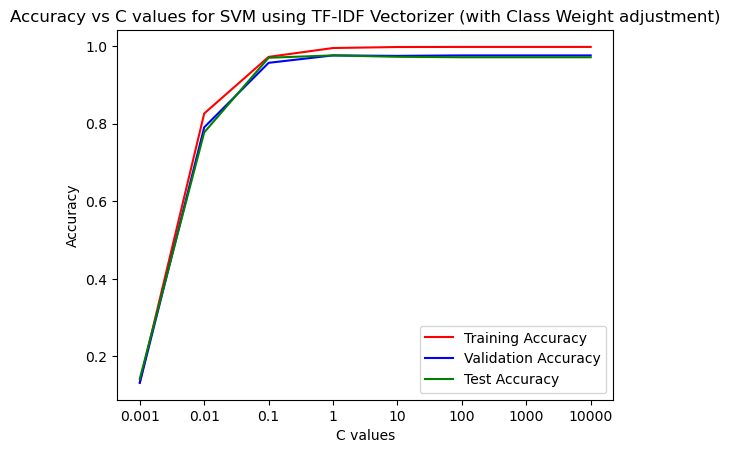

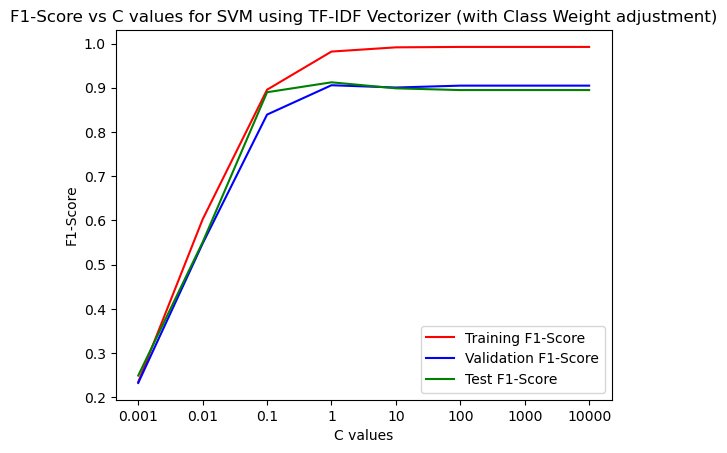

In [30]:
index = list(range(len(C_values)))

plt.plot(index, train_accuracy, linestyle='-', color='r', label='Training Accuracy')
plt.plot(index, validation_accuracy, linestyle='-', color='b', label='Validation Accuracy')  
plt.plot(index, test_accuracy, linestyle='-', color='g', label='Test Accuracy')
plt.xticks(index, C_values)
plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C values for SVM using TF-IDF Vectorizer (with Class Weight adjustment)')
plt.legend()

plt.show()

plt.plot(index, train_f1, linestyle='-', color='r', label='Training F1-Score')
plt.plot(index, validation_f1, linestyle='-', color='b', label='Validation F1-Score')  
plt.plot(index, test_f1, linestyle='-', color='g', label='Test F1-Score')
plt.xticks(index, C_values)
plt.xlabel('C values')
plt.ylabel('F1-Score')
plt.title('F1-Score vs C values for SVM using TF-IDF Vectorizer (with Class Weight adjustment)')
plt.legend()

plt.show()

In [31]:
print(f'Max Training Accuracy {round(max(train_accuracy),4)} when C_value is {C_values[train_accuracy.index(max(train_accuracy))]}')
print(f'Max Training F1-Score {round(max(train_f1),4)} when C_value is {C_values[train_f1.index(max(train_f1))]} \n')
print(f'Max Validation Accuracy {round(max(validation_accuracy),4)} when C_value is {C_values[validation_accuracy.index(max(validation_accuracy))]}')
print(f'Max Validation F1-Score {round(max(validation_f1),4)} when C_value is {C_values[validation_f1.index(max(validation_f1))]} \n')
print(f'Max Test Accuracy {round(max(test_accuracy),4)} when C_value is {C_values[test_accuracy.index(max(test_accuracy))]}')
print(f'Max Test F1-Score {round(max(test_f1),4)} when C_value is {C_values[test_f1.index(max(test_f1))]}')

Max Training Accuracy 0.9979 when C_value is 100
Max Training F1-Score 0.9923 when C_value is 100 

Max Validation Accuracy 0.9761 when C_value is 1
Max Validation F1-Score 0.9057 when C_value is 1 

Max Test Accuracy 0.9761 when C_value is 1
Max Test F1-Score 0.9123 when C_value is 1


In [32]:
print(f'Training Accuracy {round(train_accuracy[C_values.index(1)],4)} when C_value is 1')
print(f'Training F1-Score {round(train_f1[C_values.index(1)],4)} when C_value is 1 \n')
print(f'Validation Accuracy {round(validation_accuracy[C_values.index(1)],4)} when C_value is 1')
print(f'Validation F1-Score {round(validation_f1[C_values.index(1)],4)} when C_value is 1 \n')
print(f'Test Accuracy {round(test_accuracy[C_values.index(1)],4)} when C_value is 1')
print(f'Test F1-Score {round(test_f1[C_values.index(1)],4)} when C_value is 1')

Training Accuracy 0.9951 when C_value is 1
Training F1-Score 0.9818 when C_value is 1 

Validation Accuracy 0.9761 when C_value is 1
Validation F1-Score 0.9057 when C_value is 1 

Test Accuracy 0.9761 when C_value is 1
Test F1-Score 0.9123 when C_value is 1


# Using Word2Vec Embedding

Source for this code is https://spotintelligence.com/2023/02/15/word2vec-for-text-classification/#TF-IDF_vs_Word2Vec

In [33]:
from gensim.models import Word2Vec

X_train = train_data[2]
X_train.fillna("", inplace=True)

X_valid = valid_data[2]
X_valid.fillna("", inplace=True)

X_test = test_data[2]
X_test.fillna("", inplace=True)

sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

In [34]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [35]:
X_train = np.array([vectorize(sentence) for sentence in X_train])
X_valid = np.array([vectorize(sentence) for sentence in X_valid])
X_test = np.array([vectorize(sentence) for sentence in X_test])

train_accuracy = []
train_f1 = []
validation_accuracy = []
validation_f1 = []
test_accuracy = []
test_f1 = []

C_values = [0.001,0.01,0.1,1,10,100,1000,10000]
for c in C_values:
    base_model = SVC(C=c,kernel="linear")
    base_model.fit(X_train,y_train)
    
    y_pred_train = base_model.predict(X_train)
    y_pred_valid = base_model.predict(X_valid)
    y_pred_test = base_model.predict(X_test)
    
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    train_f1.append(f1_score(y_train, y_pred_train))
    
    validation_accuracy.append(accuracy_score(y_valid, y_pred_valid))
    validation_f1.append(f1_score(y_valid, y_pred_valid))
    
    test_accuracy.append(accuracy_score(y_test, y_pred_test))
    test_f1.append(f1_score(y_test, y_pred_test))

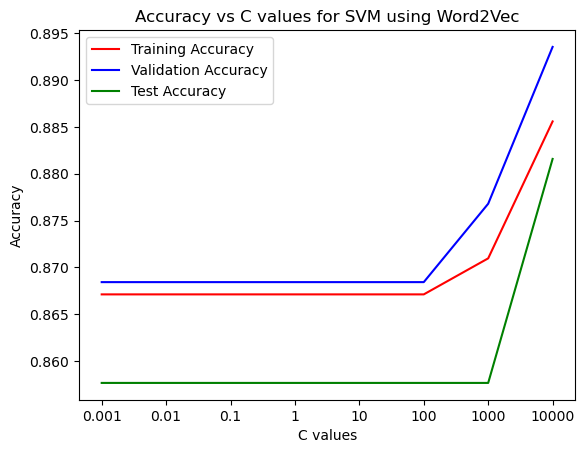

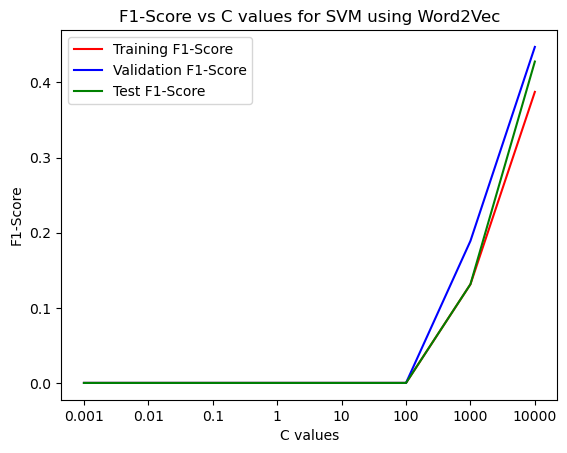

In [36]:
index = list(range(len(C_values)))

plt.plot(index, train_accuracy, linestyle='-', color='r', label='Training Accuracy')
plt.plot(index, validation_accuracy, linestyle='-', color='b', label='Validation Accuracy')  
plt.plot(index, test_accuracy, linestyle='-', color='g', label='Test Accuracy')
plt.xticks(index, C_values)
plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C values for SVM using Word2Vec')
plt.legend()

plt.show()

plt.plot(index, train_f1, linestyle='-', color='r', label='Training F1-Score')
plt.plot(index, validation_f1, linestyle='-', color='b', label='Validation F1-Score')  
plt.plot(index, test_f1, linestyle='-', color='g', label='Test F1-Score')
plt.xticks(index, C_values)
plt.xlabel('C values')
plt.ylabel('F1-Score')
plt.title('F1-Score vs C values for SVM using Word2Vec')
plt.legend()

plt.show()

In [37]:
print(f'Max Training Accuracy {round(max(train_accuracy),4)} when C_value is {C_values[train_accuracy.index(max(train_accuracy))]}')
print(f'Max Training F1-Score {round(max(train_f1),4)} when C_value is {C_values[train_f1.index(max(train_f1))]} \n')
print(f'Max Validation Accuracy {round(max(validation_accuracy),4)} when C_value is {C_values[validation_accuracy.index(max(validation_accuracy))]}')
print(f'Max Validation F1-Score {round(max(validation_f1),4)} when C_value is {C_values[validation_f1.index(max(validation_f1))]} \n')
print(f'Max Test Accuracy {round(max(test_accuracy),4)} when C_value is {C_values[test_accuracy.index(max(test_accuracy))]}')
print(f'Max Test F1-Score {round(max(test_f1),4)} when C_value is {C_values[test_f1.index(max(test_f1))]}')

Max Training Accuracy 0.8856 when C_value is 10000
Max Training F1-Score 0.3874 when C_value is 10000 

Max Validation Accuracy 0.8935 when C_value is 10000
Max Validation F1-Score 0.4472 when C_value is 10000 

Max Test Accuracy 0.8816 when C_value is 10000
Max Test F1-Score 0.4277 when C_value is 10000


As there is a sudden upward trend when C is 10000, further inspection is being done

In [38]:
train_accuracy = []
train_f1 = []
validation_accuracy = []
validation_f1 = []
test_accuracy = []
test_f1 = []

C_values = [10000, 30000, 50000, 70000, 100000]
for c in C_values:
    base_model = SVC(C=c,kernel="linear")
    base_model.fit(X_train,y_train)
    
    y_pred_train = base_model.predict(X_train)
    y_pred_valid = base_model.predict(X_valid)
    y_pred_test = base_model.predict(X_test)
    
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    train_f1.append(f1_score(y_train, y_pred_train))
    
    validation_accuracy.append(accuracy_score(y_valid, y_pred_valid))
    validation_f1.append(f1_score(y_valid, y_pred_valid))
    
    test_accuracy.append(accuracy_score(y_test, y_pred_test))
    test_f1.append(f1_score(y_test, y_pred_test))

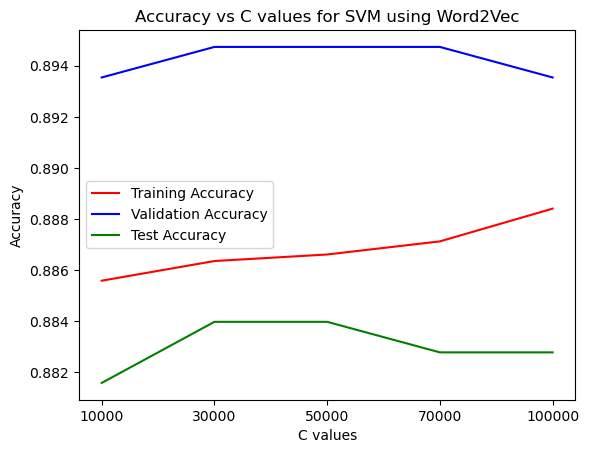

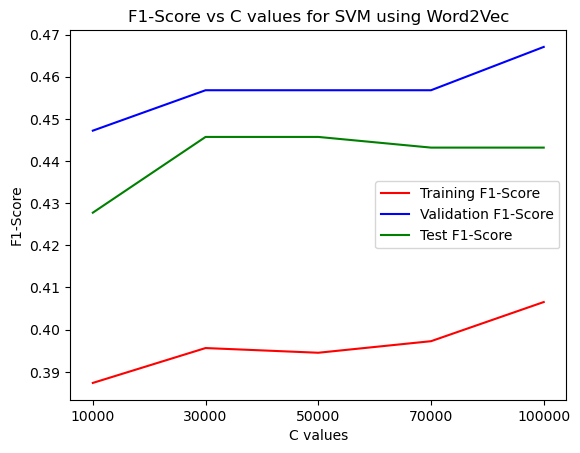

In [39]:
index = list(range(len(C_values)))

plt.plot(index, train_accuracy, linestyle='-', color='r', label='Training Accuracy')
plt.plot(index, validation_accuracy, linestyle='-', color='b', label='Validation Accuracy')  
plt.plot(index, test_accuracy, linestyle='-', color='g', label='Test Accuracy')
plt.xticks(index, C_values)
plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C values for SVM using Word2Vec')
plt.legend()

plt.show()

plt.plot(index, train_f1, linestyle='-', color='r', label='Training F1-Score')
plt.plot(index, validation_f1, linestyle='-', color='b', label='Validation F1-Score')  
plt.plot(index, test_f1, linestyle='-', color='g', label='Test F1-Score')
plt.xticks(index, C_values)
plt.xlabel('C values')
plt.ylabel('F1-Score')
plt.title('F1-Score vs C values for SVM using Word2Vec')
plt.legend()

plt.show()

In [40]:
print(f'Max Training Accuracy {round(max(train_accuracy),4)} when C_value is {C_values[train_accuracy.index(max(train_accuracy))]}')
print(f'Max Training F1-Score {round(max(train_f1),4)} when C_value is {C_values[train_f1.index(max(train_f1))]} \n')
print(f'Max Validation Accuracy {round(max(validation_accuracy),4)} when C_value is {C_values[validation_accuracy.index(max(validation_accuracy))]}')
print(f'Max Validation F1-Score {round(max(validation_f1),4)} when C_value is {C_values[validation_f1.index(max(validation_f1))]} \n')
print(f'Max Test Accuracy {round(max(test_accuracy),4)} when C_value is {C_values[test_accuracy.index(max(test_accuracy))]}')
print(f'Max Test F1-Score {round(max(test_f1),4)} when C_value is {C_values[test_f1.index(max(test_f1))]}')

Max Training Accuracy 0.8884 when C_value is 100000
Max Training F1-Score 0.4065 when C_value is 100000 

Max Validation Accuracy 0.8947 when C_value is 30000
Max Validation F1-Score 0.4671 when C_value is 100000 

Max Test Accuracy 0.884 when C_value is 30000
Max Test F1-Score 0.4457 when C_value is 30000


In [42]:
train_accuracy = []
train_f1 = []
validation_accuracy = []
validation_f1 = []
test_accuracy = []
test_f1 = []

C_values = [0.001,0.01,0.1,1,10,100,1000,10000,30000, 50000, 70000, 100000]
for c in C_values:
    base_model = SVC(C=c,kernel="linear", class_weight= 'balanced')
    base_model.fit(X_train,y_train)
    
    y_pred_train = base_model.predict(X_train)
    y_pred_valid = base_model.predict(X_valid)
    y_pred_test = base_model.predict(X_test)
    
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    train_f1.append(f1_score(y_train, y_pred_train))
    
    validation_accuracy.append(accuracy_score(y_valid, y_pred_valid))
    validation_f1.append(f1_score(y_valid, y_pred_valid))
    
    test_accuracy.append(accuracy_score(y_test, y_pred_test))
    test_f1.append(f1_score(y_test, y_pred_test))

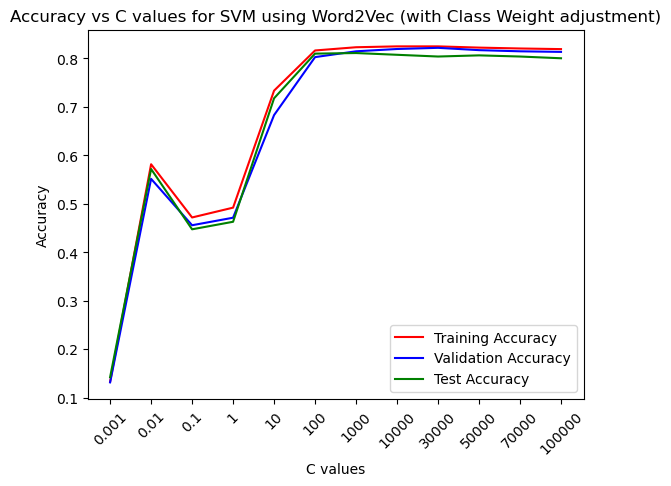

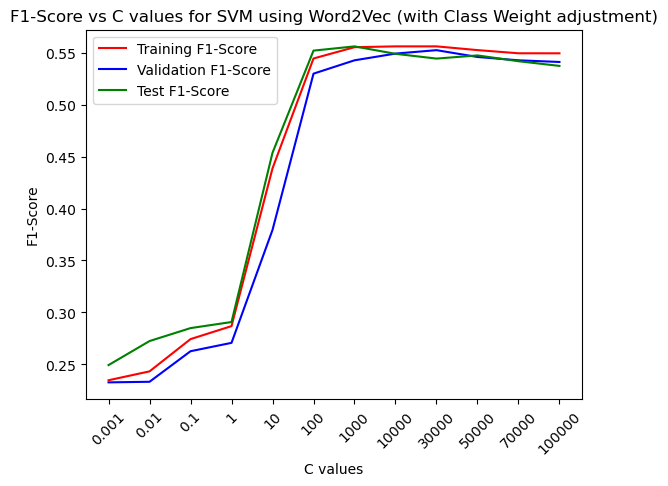

In [46]:
index = list(range(len(C_values)))

plt.plot(index, train_accuracy, linestyle='-', color='r', label='Training Accuracy')
plt.plot(index, validation_accuracy, linestyle='-', color='b', label='Validation Accuracy')  
plt.plot(index, test_accuracy, linestyle='-', color='g', label='Test Accuracy')
plt.xticks(index, C_values)
plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C values for SVM using Word2Vec (with Class Weight adjustment)')
plt.xticks(rotation=45)
plt.legend()

plt.show()

plt.plot(index, train_f1, linestyle='-', color='r', label='Training F1-Score')
plt.plot(index, validation_f1, linestyle='-', color='b', label='Validation F1-Score')  
plt.plot(index, test_f1, linestyle='-', color='g', label='Test F1-Score')
plt.xticks(index, C_values)
plt.xlabel('C values')
plt.ylabel('F1-Score')
plt.title('F1-Score vs C values for SVM using Word2Vec (with Class Weight adjustment)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [44]:
print(f'Max Training Accuracy {round(max(train_accuracy),4)} when C_value is {C_values[train_accuracy.index(max(train_accuracy))]}')
print(f'Max Training F1-Score {round(max(train_f1),4)} when C_value is {C_values[train_f1.index(max(train_f1))]} \n')
print(f'Max Validation Accuracy {round(max(validation_accuracy),4)} when C_value is {C_values[validation_accuracy.index(max(validation_accuracy))]}')
print(f'Max Validation F1-Score {round(max(validation_f1),4)} when C_value is {C_values[validation_f1.index(max(validation_f1))]} \n')
print(f'Max Test Accuracy {round(max(test_accuracy),4)} when C_value is {C_values[test_accuracy.index(max(test_accuracy))]}')
print(f'Max Test F1-Score {round(max(test_f1),4)} when C_value is {C_values[test_f1.index(max(test_f1))]}')

Max Training Accuracy 0.8248 when C_value is 10000
Max Training F1-Score 0.5562 when C_value is 10000 

Max Validation Accuracy 0.8218 when C_value is 30000
Max Validation F1-Score 0.5526 when C_value is 30000 

Max Test Accuracy 0.811 when C_value is 1000
Max Test F1-Score 0.5562 when C_value is 1000
